##Setup

###Library imports

In [275]:
!pip install bayesian-optimization

from bayes_opt import BayesianOptimization
import kagglehub
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

###Load breast cancer dataset
Source: https://www.kaggle.com/datasets/amandam1/breastcancerdataset

In [276]:
# Download latest version and print filepath
path = kagglehub.dataset_download("amandam1/breastcancerdataset")
print("Path to dataset files:", path)

#Get filename
print(os.listdir('/root/.cache/kagglehub/datasets/amandam1/breastcancerdataset/versions/1'))

#Read file to dataframe
df = pd.read_csv('/root/.cache/kagglehub/datasets/amandam1/breastcancerdataset/versions/1/BRCA.csv')

Path to dataset files: /root/.cache/kagglehub/datasets/amandam1/breastcancerdataset/versions/1
['BRCA.csv']


Patient_ID: unique identifier id of a patient

Age: age at diagnosis (Years)

Gender: Male/Female

Protein1, Protein2, Protein3, Protein4: expression levels (undefined units)

Tumour_Stage: I, II, III

Histology: Infiltrating Ductal Carcinoma, Infiltrating Lobular Carcinoma, Mucinous Carcinoma

ER status: Positive/Negative

PR status: Positive/Negative

HER2 status: Positive/Negative

Surgery_type: Lumpectomy, Simple Mastectomy, Modified Radical Mastectomy, Other

Date_of_Surgery: Date on which surgery was performed (in DD-MON-YY)

Date_of_Last_Visit: Date of last visit (in DD-MON-YY) [can be null, in case the patient didn’t visited again after the surgery]

Patient_Status: Alive/Dead [can be null, in case the patient didn’t visited again after the surgery and there is no information available whether the patient is alive or dead].

##Preprocessing and data exploration

In [277]:
#Transform tumor stage to categorical data
df['Tumour_Stage'] = pd.Categorical(df['Tumour_Stage'])

#Create protein and tumor specific df subset
pdf = df[['Tumour_Stage', 'Protein1', 'Protein2', 'Protein3', 'Protein4']]

#Count NaN
total_nan_count = pdf.isnull().sum().sum()
print(f"Total NaN count: {total_nan_count}\n")
#Drop NaN
pdf.dropna(inplace=True)

#Get tumour categories
print(f"Tumour categories: {df['Tumour_Stage'].value_counts()}\n")

#Get minimum/maximum values of protein columns
for i, column in enumerate(pdf.columns[1:]):
    print(f"Value range of {column}: ({pdf[column].min()}, {pdf[column].max()})")
    #-2.5, 3.5

Total NaN count: 35

Tumour categories: Tumour_Stage
II     189
III     81
I       64
Name: count, dtype: int64

Value range of Protein1: (-2.3409, 1.5936)
Value range of Protein2: (-0.97873, 3.4022)
Value range of Protein3: (-1.6274, 2.1934)
Value range of Protein4: (-2.0255, 1.6299)


<ipython-input-277-af2582d9b640>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf.dropna(inplace=True)


###Plot mean protein levels per tumor stage (Bar chart)

<ipython-input-278-76040db96ecf>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_age_per_stage = pdf.groupby('Tumour_Stage')[column].mean()


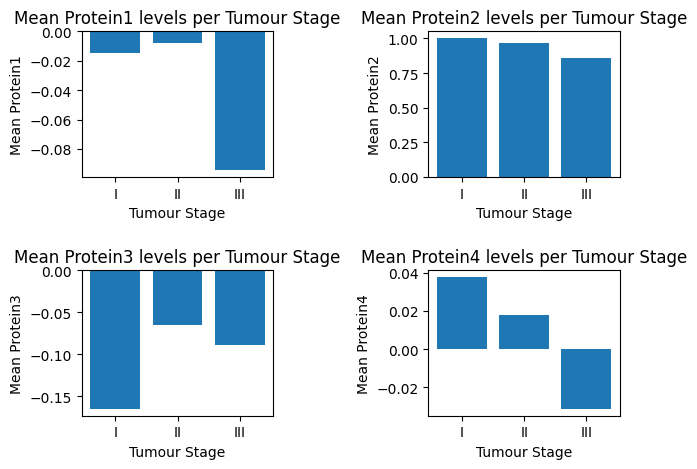

In [278]:
fig, axs = plt.subplots(2, 2)
axs = axs.flatten() #Flatten the axs array so it can be iterated using 1 loop
for i, column in enumerate(pdf.columns[1:]): #Iterate over the columns and track the index with enumerate
  # Calculate the mean age for each tumour stage
  mean_age_per_stage = pdf.groupby('Tumour_Stage')[column].mean()

  # Use the tumour stages as x-values and the mean age for each tumor stage as the y values
  axs[i].bar(mean_age_per_stage.index, mean_age_per_stage.values)
  axs[i].set_xlabel("Tumour Stage")
  axs[i].set_ylabel(f"Mean {column}")
  axs[i].set_title(f"Mean {column} levels per Tumour Stage")

plt.tight_layout(h_pad=2.0, w_pad=6.0)
plt.show()

<ipython-input-297-85467b14fca3>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_age_per_stage = pdf.groupby('Tumour_Stage')[column].median()


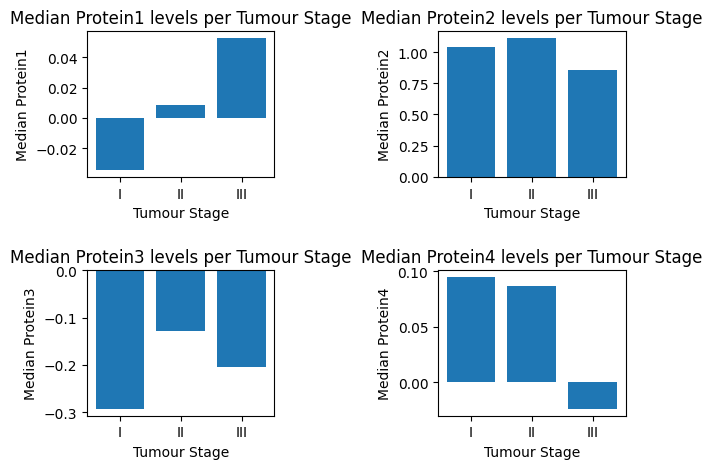

In [297]:
fig, axs = plt.subplots(2, 2)
axs = axs.flatten() #Flatten the axs array so it can be iterated using 1 loop
for i, column in enumerate(pdf.columns[1:]): #Iterate over the columns and track the index with enumerate
  # Calculate the mean age for each tumour stage
  median_age_per_stage = pdf.groupby('Tumour_Stage')[column].median()

  # Use the tumour stages as x-values and the mean age for each tumor stage as the y values
  axs[i].bar(median_age_per_stage.index, median_age_per_stage.values)
  axs[i].set_xlabel("Tumour Stage")
  axs[i].set_ylabel(f"Median {column}")
  axs[i].set_title(f"Median {column} levels per Tumour Stage")

plt.tight_layout(h_pad=2.0, w_pad=6.0)
plt.show()

###Plot protein levels per tumor stage (Line graph)

<ipython-input-279-9fe986230e82>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_age_per_stage = df.groupby('Tumour_Stage')[column].mean()


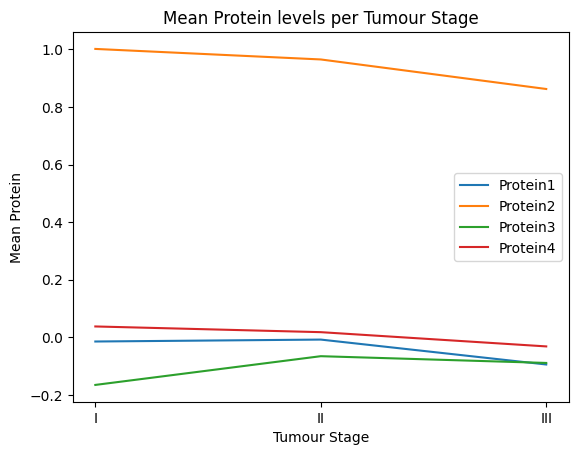

In [279]:
plt.figure()
for i, column in enumerate(pdf.columns[1:]):
  # Calculate the mean age for each tumour stage
  mean_age_per_stage = df.groupby('Tumour_Stage')[column].mean()
  # Use the tumour stages as x-values and the mean age for each tumor stage as the y values
  plt.plot(mean_age_per_stage.index, mean_age_per_stage.values,
           label=column)
plt.xlabel('Tumour Stage')
plt.ylabel('Mean Protein')
plt.title('Mean Protein levels per Tumour Stage')
plt.legend()
plt.show()

##Supervised learners

###Cross validation helper method

In [298]:
#Initialize training data
X = pdf[['Protein1', 'Protein2', 'Protein3', 'Protein4']].values
#Initialize label class
y = pdf['Tumour_Stage']

#Define training method
def train_with_kfolds(classifier, X, y, num_folds=3):
  ss = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  f1_scores = [] #Initialize a list to store f1 scores
  for train_index, test_index in ss.split(X, y):
      train_features, test_features = X[train_index], X[test_index]
      train_labels, test_labels = y[train_index], y[test_index]
      #Fit classifier
      classifier.fit(train_features, train_labels)
      #Get predictions
      predictions = classifier.predict(test_features)
      #Get F1 score
      f1 = f1_score(test_labels, predictions, average='macro')
      #Append f1 score to list
      f1_scores.append(f1)
  #Return the average f1 score across all folds
  return sum(f1_scores) / len(f1_scores)

###Support vector machine

In [299]:
#Initialize SVM classifier
svm = SVC()
#Train using K-folds and print f1 score
print(f"Unoptimized SVM F1 score: {round(train_with_kfolds(svm, X, y), 4)}")
#Fitness: 0.2401

Unoptimized SVM F1 score: 0.2401


###K-nearest neighbors

In [300]:
#Initialize KNN classifier
knn = KNeighborsClassifier()
#Train using K-folds + update classifier
print(f"Unoptimized KNN F1 score: {round(train_with_kfolds(knn, X, y), 4)}")
#Fitness: 0.3052

Unoptimized KNN F1 score: 0.3052


##Bayesian optimization of supervised learners

###Support vector machine (With Bayesian optimization)

In [319]:
def train_and_score_svm(bayes_c):
    svm = SVC(
        C=bayes_c
    )
    return train_with_kfolds(svm, X, y)

#Define parameter space
pbounds = {
    'bayes_c': (0, 300)
    }

#Define optimizer
optimizer = BayesianOptimization(
    f=train_and_score_svm, #Pass the function, not the result of the function
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(
    init_points=2,
    n_iter=3,
)

print(f"Optimal parameters for SVM: {optimizer.max}\n")
#Optimal c: 285.2
#Fitness: 0.2757

|   iter    |  target   |  bayes_c  |
-------------------------------------
| 1         | 0.2756    | 112.4     |
| 2         | 0.2757    | 285.2     |
| 3         | 0.2757    | 286.5     |
| 4         | 0.2409    | 0.04732   |
| 5         | 0.268     | 184.3     |
Optimal parameters for SVM: {'target': 0.2756851183826868, 'params': {'bayes_c': 285.21429192297484}}



###KNN (With Bayesian optimization)

In [321]:
def train_and_score_knn(bayes_nn):
    knn = KNeighborsClassifier(
        n_neighbors=int(bayes_nn)
    )
    return train_with_kfolds(knn, X, y)

#Define parameter space
pbounds = {
    'bayes_nn': (1, 300)
    }

#Define optimizer
optimizer = BayesianOptimization(
    f=train_and_score_knn, #Pass the function, not the result of the function
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(
    init_points=2,
    n_iter=3,
)

print(f"Optimal parameters for KNN: {optimizer.max}\n")
#Optimal nn: 1, 2
#Fitness: 0.3053

|   iter    |  target   | bayes_nn  |
-------------------------------------
| 1         | 0.2409    | 113.0     |
| 2         | 0.2409    | 285.3     |
| 3         | 0.305     | 1.003     |
| 4         | 0.3053    | 2.09      |
| 5         | 0.2409    | 45.18     |
Optimal parameters for KNN: {'target': 0.30532829421412067, 'params': {'bayes_nn': 2.0903641326182045}}

